# Modified Visual-Social CNN Model

## 1 Introduction
This notebook is used to perform dimensionality reduction on the input features, and build, train and evaluate the modified VSCNN model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import IncrementalPCA
import tensorflow as tf
from scipy import stats
import time

## 2 Workflow
The workflow of this activity is as follows.
- Data Preparation
- Dimensionality Reduction
- Model Building
- Model Training
- Model Evaluation

## 3 Data Preparation

In [ ]:
# Loading MobileNetV2 image features
mobilenetv2_features = np.load('/content/drive/MyDrive/M.Sc. Dissertation/Data & Code/mobilenetv2_features_20%.npy')
mobilenetv2_features

array([[0.        , 0.93492925, 0.        , ..., 0.11415859, 0.14586146,
        3.7020535 ],
       [0.8203789 , 0.        , 1.4139705 , ..., 1.3651012 , 0.        ,
        3.9168155 ],
       [0.05364434, 0.        , 0.        , ..., 0.22563407, 1.5544231 ,
        3.3605235 ],
       ...,
       [0.        , 0.        , 0.04954114, ..., 1.5562689 , 0.        ,
        0.68286645],
       [0.        , 0.28807175, 0.        , ..., 0.        , 0.        ,
        0.0904926 ],
       [1.6652962 , 0.32013667, 0.        , ..., 4.2475276 , 0.08023167,
        1.6318028 ]], dtype=float32)

In [ ]:
mobilenetv2_features.shape

(54650, 1280)

In [ ]:
# Loading social features
social_features = pd.read_json('/content/drive/MyDrive/M.Sc. Dissertation/Data & Code/social_data_sample_20%.json')
social_features.head()

,Uid,photo_count,ispro,canbuypro,timezone_timezone_id,timezone_offset,Geoaccuracy,Category,Concept,Subcategory,img_path,label,TitleLen,TagNum,DaysSinceFirstPhoto,DayOfWeek,Month,Time,City,Country
0,3175@N73,999,1,0,8,0,0,Entertainment,rnb,Music,train/3175@N73/16586.jpg,9.67,22,46,1173,Friday,July,Afternoon,Unknown,Unknown
1,3175@N73,20032,1,0,5,-8,0,Entertainment,rnb,Music,train/3175@N73/16587.jpg,8.85,22,46,1700,Friday,July,Afternoon,Unknown,Unknown
2,3175@N73,3305,0,1,5,-8,0,Entertainment,rnb,Music,train/3175@N73/16588.jpg,8.67,22,46,1163,Friday,July,Afternoon,Unknown,Unknown
3,3175@N73,3305,0,1,5,-8,0,Entertainment,rnb,Music,train/3175@N73/16589.jpg,8.61,22,46,1163,Friday,July,Afternoon,Unknown,Unknown
4,3175@N73,3305,0,1,5,-8,0,Entertainment,rnb,Music,train/3175@N73/16590.jpg,9.00,22,46,1163,Friday,July,Afternoon,Unknown,Unknown


In [ ]:
social_features.shape

(54650, 20)

In [ ]:
# Dropping extraneous variables
social_features = social_features.drop(columns=['timezone_timezone_id','img_path'])

In [ ]:
# Fixing data types of variables
social_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54650 entries, 0 to 54649
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Uid                  54650 non-null  object 
 1   photo_count          54650 non-null  int64  
 2   ispro                54650 non-null  int64  
 3   canbuypro            54650 non-null  int64  
 4   timezone_offset      54650 non-null  int64  
 5   Geoaccuracy          54650 non-null  int64  
 6   Category             54650 non-null  object 
 7   Concept              54650 non-null  object 
 8   Subcategory          54650 non-null  object 
 9   label                54650 non-null  float64
 10  TitleLen             54650 non-null  int64  
 11  TagNum               54650 non-null  int64  
 12  DaysSinceFirstPhoto  54650 non-null  int64  
 13  DayOfWeek            54650 non-null  object 
 14  Month                54650 non-null  object 
 15  Time                 54650 non-null 

In [ ]:
# Converting some categorical variables to numeric variables to reduce the dimensionality of the dataset
social_features['DayOfWeek'].value_counts()

Saturday     12517
Sunday        9809
Friday        8416
Thursday      7202
Monday        5593
Wednesday     5571
Tuesday       5542
Name: DayOfWeek, dtype: int64

In [ ]:
social_features['DayOfWeek'] = social_features['DayOfWeek'].map({
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
})

In [ ]:
social_features['DayOfWeek'].value_counts()

5    12517
6     9809
4     8416
3     7202
0     5593
2     5571
1     5542
Name: DayOfWeek, dtype: int64

In [ ]:
social_features['Month'].value_counts()

February     8400
January      7310
December     7098
October      6299
November     4566
September    4297
August       3888
July         3684
June         3399
May          2909
March        1588
April        1212
Name: Month, dtype: int64

In [ ]:
social_features['Month'] = social_features['Month'].map({
    'January': 0,
    'February': 1,
    'March': 2,
    'April': 3,
    'May': 4,
    'June': 5,
    'July': 6,
    'August': 7,
    'September': 8,
    'October': 9,
    'November': 10,
    'December': 11
})
social_features['Month'].dtype

dtype('int64')

In [ ]:
social_features['Month'].value_counts()

1     8400
0     7310
11    7098
9     6299
10    4566
8     4297
7     3888
6     3684
5     3399
4     2909
2     1588
3     1212
Name: Month, dtype: int64

In [ ]:
social_features['Time'].value_counts()

Morning      20304
Night        17712
Afternoon    12115
Evening       4519
Name: Time, dtype: int64

In [ ]:
social_features['Time'] = social_features['Time'].map({
    'Morning': 0,
    'Afternoon': 1,
    'Evening': 2,
    'Night': 3
})

social_features['Time'].dtype

dtype('int64')

In [ ]:
social_features['Time'].value_counts()

0    20304
3    17712
1    12115
2     4519
Name: Time, dtype: int64

In [ ]:
# Obtaining dummy variables from categorical variables
social_features_dummies = pd.get_dummies(social_features)
social_features_dummies.shape

(54650, 5053)

In [ ]:
social_features_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54650 entries, 0 to 54649
Columns: 5053 entries, photo_count to Country_대한민국
dtypes: float64(1), int64(11), uint8(5041)
memory usage: 268.1 MB


In [ ]:
# Splitting the data into train and test sets
social_train, social_test, mobilenetv2_train, mobilenetv2_test = train_test_split(social_features_dummies,mobilenetv2_features,test_size=0.2,random_state=1,stratify=social_features['Uid'])

In [ ]:
for x in [social_train, social_test, mobilenetv2_train, mobilenetv2_test]:
    print(x.shape)

(43720, 5053)
(10930, 5053)
(43720, 1280)
(10930, 1280)


In [ ]:
# Extracting the response variable from the datasets
y_train = social_train['label']
y_test = social_test['label']

In [ ]:
social_train = social_train.drop(columns='label')
social_test = social_test.drop(columns='label')

## 4 Dimensionality Reduction

### 4.1 Social Features

In [ ]:
# Obtaining principal components of social features
pca = IncrementalPCA(batch_size=1024)
pca.fit(social_train)

IncrementalPCA(batch_size=1024)

/tmp/ipykernel_64264/4099540559.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


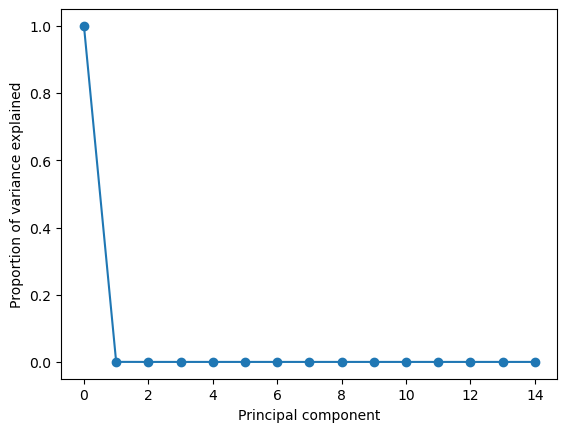

In [ ]:
# Creating a scree plot
fig, ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_[:15], 'o-')
ax.set_xlabel('Principal component')
ax.set_ylabel('Proportion of variance explained')
fig.show()

In [ ]:
pca.explained_variance_ratio_[:14].sum()*100

99.99999996869931

Although the first principal component explains almost all the variance, we will use 14 principal components, which together explain 99.9% of the variance.

In [ ]:
social_train_reduced = pca.transform(social_train)[:,:14]
social_test_reduced = pca.transform(social_test)[:,:14]
print(social_train_reduced.shape)
print(social_test_reduced.shape)

(43720, 14)
(10930, 14)


In [ ]:
np.save('social_train_reduced.npy',social_train_reduced)
np.save('social_test_reduced.npy',social_test_reduced)

### 4.2 Image Features

In [ ]:
# Obtaining principal components of image features
pca = IncrementalPCA()
pca.fit(mobilenetv2_train)

IncrementalPCA()

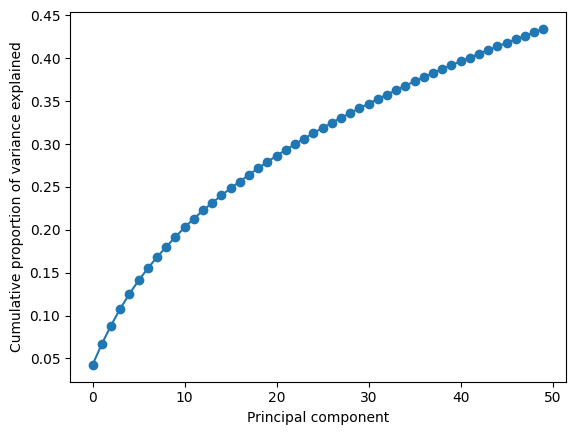

In [ ]:
# Creating a scree plot
fig, ax = plt.subplots()
ax.plot(pca.explained_variance_ratio_.cumsum()[:50], 'o-')
ax.set_xlabel('Principal component')
ax.set_ylabel('Cumulative proportion of variance explained')
fig.show()

In [ ]:
# Obtaining the index of the principal component that explains at least 45% of the variance
np.argmax(pca.explained_variance_ratio_.cumsum()>0.45)

54

Thus, we will use 54 principal components that explain over 45% of the variance.

In [ ]:
mobilenetv2_train_reduced = pca.transform(mobilenetv2_train)[:,:54]
mobilenetv2_test_reduced = pca.transform(mobilenetv2_test)[:,:54]
print(mobilenetv2_train_reduced.shape)
print(mobilenetv2_test_reduced.shape)

(43720, 54)
(10930, 54)


In [ ]:
np.save('mobilenetv2_train_reduced.npy',mobilenetv2_train_reduced)
np.save('mobilenetv2_test_reduced.npy',mobilenetv2_test_reduced)

In [ ]:
# Measuring the time required to perform dimensionality reduction for a sample of 8
t = time.time()
pca.transform(mobilenetv2_test[:8,:])[:,:54]
time.time() - t

0.009192705154418945

## 5 Building the VSCNN Model

In [ ]:
# Specifying the architecture of the convolutional network

def conv_net(A):
    A_prime = tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=2, activation='relu')(A)
    A_prime = tf.keras.layers.Dropout(0.1)(A_prime)
    A_prime = tf.keras.layers.BatchNormalization()(A_prime)
    A_prime = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu')(A_prime)
    A_prime = tf.keras.layers.Dropout(0.1)(A_prime)
    A_prime = tf.keras.layers.BatchNormalization()(A_prime)
    A_prime = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')(A_prime)
    Z = tf.keras.layers.Flatten()(A_prime)
    return Z

In [ ]:
# Specifying the architecture of the modified VSCNN model

def VSCNN(A_shape):
    A = tf.keras.Input(A_shape)
    Z = conv_net(A)

    Z = tf.keras.layers.Dropout(0.1)(Z)
    Z = tf.keras.layers.Dense(1024,'relu')(Z)
    Z = tf.keras.layers.Dropout(0.2)(Z)
    Z = tf.keras.layers.Dense(512,'relu')(Z)
    y = tf.keras.layers.Dense(1)(Z)

    model = tf.keras.Model(inputs=[A], outputs=y)
    return model

In [ ]:
model = VSCNN((68,1))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 68, 1)]           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 32, 32)            192       
                                                                 
 dropout_4 (Dropout)         (None, 32, 32)            0         
                                                                 
 batch_normalization_2 (Bat  (None, 32, 32)            128       
 chNormalization)                                                
                                                                 
 conv1d_4 (Conv1D)           (None, 28, 64)            10304     
                                                                 
 dropout_5 (Dropout)         (None, 28, 64)            0         
                                                           

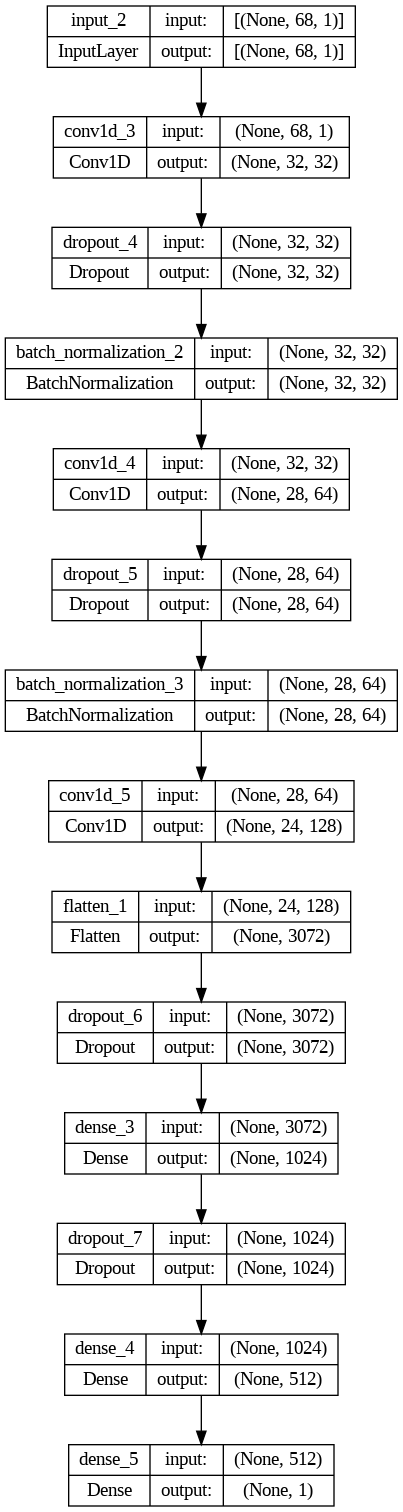

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## 6 Training the VSCNN Model

In [ ]:
# Compiling the model
model.compile(optimizer='adam',loss='mae',metrics=['mae'])

In [ ]:
# Preparing the data for training
social_train_reduced = np.load('/content/drive/MyDrive/M.Sc. Dissertation/Data & Code/social_train_reduced.npy')
social_test_reduced = np.load('/content/drive/MyDrive/M.Sc. Dissertation/Data & Code/social_test_reduced.npy')

In [ ]:
mobilenetv2_train_reduced = np.load('/content/drive/MyDrive/M.Sc. Dissertation/Data & Code/mobilenetv2_train_reduced.npy')
mobilenetv2_test_reduced = np.load('/content/drive/MyDrive/M.Sc. Dissertation/Data & Code/mobilenetv2_test_reduced.npy')

In [ ]:
all_train_reduced = np.concatenate((social_train_reduced,mobilenetv2_train_reduced),axis=1)
all_test_reduced = np.concatenate((social_test_reduced,mobilenetv2_test_reduced),axis=1)
print(all_train_reduced.shape)
print(all_test_reduced.shape)

(43720, 68)
(10930, 68)


In [ ]:
# Preparing the validation data
all_val_reduced = all_test_reduced[:all_test_reduced.shape[0]//2,:]
all_test_reduced = all_test_reduced[all_test_reduced.shape[0]//2:,:]

In [ ]:
y_val = y_test[:y_test.shape[0]//2]
y_test = y_test[y_test.shape[0]//2:]

In [ ]:
# Training the model
callbacks = [tf.keras.callbacks.ModelCheckpoint('./weights.{epoch:02d}-{val_loss:.2f}.hdf5')]

history = model.fit(x=[all_train_reduced],y=y_train,epochs=50,batch_size=48,validation_data=(all_val_reduced,y_val),callbacks=callbacks,use_multiprocessing=True)

Epoch 1/50
911/911 [==============================] - 14s 8ms/step - loss: 2.0499 - mae: 2.0499 - val_loss: 1.9748 - val_mae: 1.9748
Epoch 2/50
 10/911 [..............................] - ETA: 5s - loss: 2.0385 - mae: 2.0385

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


911/911 [==============================] - 6s 6ms/step - loss: 1.8901 - mae: 1.8901 - val_loss: 1.9925 - val_mae: 1.9925
Epoch 3/50
911/911 [==============================] - 9s 10ms/step - loss: 1.8643 - mae: 1.8643 - val_loss: 1.8865 - val_mae: 1.8865
Epoch 4/50
911/911 [==============================] - 7s 7ms/step - loss: 1.8275 - mae: 1.8275 - val_loss: 1.8670 - val_mae: 1.8670
Epoch 5/50
911/911 [==============================] - 8s 8ms/step - loss: 1.8143 - mae: 1.8143 - val_loss: 1.8841 - val_mae: 1.8841
Epoch 6/50
911/911 [==============================] - 6s 7ms/step - loss: 1.7847 - mae: 1.7847 - val_loss: 1.7954 - val_mae: 1.7954
Epoch 7/50
911/911 [==============================] - 7s 7ms/step - loss: 1.7613 - mae: 1.7613 - val_loss: 1.8166 - val_mae: 1.8166
Epoch 8/50
911/911 [==============================] - 6s 6ms/step - loss: 1.7543 - mae: 1.7543 - val_loss: 1.7454 - val_mae: 1.7454
Epoch 9/50
911/911 [==============================] - 7s 7ms/step - loss: 1.7357 - mae

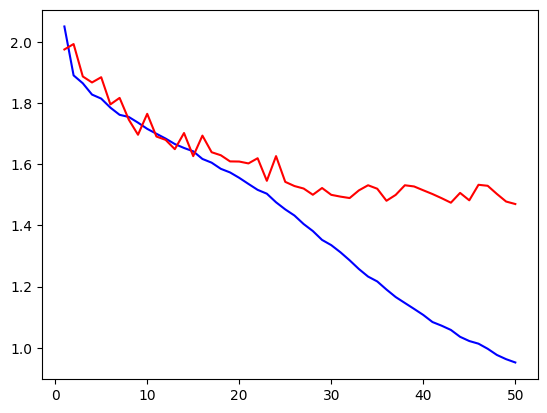

In [ ]:
# Plotting training and validation losses
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = np.arange(1,len(training_loss)+1)
fig,ax = plt.subplots()
ax.plot(epochs,training_loss,label='Training Loss',color='blue')
ax.plot(epochs,validation_loss,label='Validation Loss',color='red')
fig.show()

Training and validation losses decrease together till about epoch 20, after which the rate of improvement in validation loss slows down. The model corresponding to epoch 32, which has a low validation loss without significant overfitting will be finalised.

## 7 Evaluating the Modified VSCNN Model

In [ ]:
model = tf.keras.saving.load_model('/content/drive/MyDrive/M.Sc. Dissertation/Data & Code/weights.32-1.49.hdf5')

In [ ]:
model.evaluate(x=[all_test_reduced],y=y_test,batch_size=48,use_multiprocessing=True)

114/114 [==============================] - 0s 3ms/step - loss: 1.4433 - mae: 1.4433


[1.4433287382125854, 1.4433287382125854]

In [ ]:
# Calculating Spearman's Rho on the test set
y_test_pred = model.predict(x=[all_test_reduced],use_multiprocessing=True)
rho,p_value = stats.spearmanr(y_test_pred,y_test)

171/171 [==============================] - 1s 3ms/step


In [ ]:
rho

0.6164104726935946

Thus, the trained model has an MAE of 1.4433 and SRC of 0.616 at test time.

## 8 Measuring Inference Latency

In [ ]:
t = time.time()
model.predict(x=[all_test_reduced[:8,:]],batch_size=8,use_multiprocessing=True)
time.time() - t

1/1 [==============================] - 2s 2s/step


2.1466708183288574